# Step 2

Train a NN to fit the MNIST dataset using GAN architecture.


<div>
<img src="mnist.gif" width="500"/>
</div>


##### Imports

In [4]:
import numpy as np

import torch
import torchvision
from torch import nn
import torch.optim as optim

import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.animation

from time import time
from IPython.display import display, clear_output


##### Disabling autoscrolling for long output:

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

##### Device - GPU / CPU

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

<br><br><br>
<br><br><br>
<br><br><br>

## Hyper-parameters

In [5]:
LATENT_SIZE = 64
HIDDEN_SIZE = 256
IMAGE_SIZE = 784
NUM_EPOCHS = 300
BATCH_SIZE = 32

## Download MNIST

In [6]:
# tranfor to tensor
train_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download dataset
train_dataset = torchvision.datasets.MNIST(root='./mnist_data/', train=True, download=True,transform=train_transform)

# Normelize - same as torchvision.transforms.Normalize()
mean = train_dataset.data.numpy().mean()/255
std = train_dataset.data.numpy().std()/255
train_dataset.data = (train_dataset.data - torch.tensor(mean))/torch.tensor(std)

# use dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [54]:
for x in train_loader:
    print(x[1].size())
    break

torch.Size([32])


In [17]:
for i,(images,labels) in enumerate(train_loader):
    print(i,images.shape,labels.shape)
    break

0 torch.Size([32, 1, 28, 28]) torch.Size([32])


## Generator

In [7]:
generator_mnist = nn.Sequential(
                    nn.Linear(LATENT_SIZE, HIDDEN_SIZE),
                    nn.ReLU(),
                    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
                    nn.ReLU(),
                    nn.Linear(HIDDEN_SIZE, IMAGE_SIZE),
                    nn.Tanh()
                    )

generator_mnist = generator_mnist.to(DEVICE)
generator_mnist

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

## Discriminator

In [8]:
leak=0.2
discriminator_mnist = nn.Sequential(
                        nn.Linear(IMAGE_SIZE, HIDDEN_SIZE),
                        nn.LeakyReLU(leak),
                        nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
                        nn.LeakyReLU(leak),
                        nn.Linear(HIDDEN_SIZE, 1),
                        nn.Sigmoid()
                        )
discriminator_mnist = discriminator_mnist.to(DEVICE)
discriminator_mnist

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [26]:
# criterion
criterion = nn.BCELoss()

# Learning Rates
lr_generator     = 0.0001
lr_discriminator = 0.0004

# optimizers
optim_generator_mnist     = optim.Adam(generator_mnist.parameters(),    lr=lr_generator)
optim_discriminator_mnist = optim.Adam(discriminator_mnist.parameters(),lr=lr_discriminator)

# helper for loss
ones = torch.ones((BATCH_SIZE, 1)).to(DEVICE)
zeros = torch.zeros((BATCH_SIZE, 1)).to(DEVICE)

In [42]:
def train_step_generator():
        
        generator_mnist.zero_grad()
        
        # gen
        sample = torch.randn(BATCH_SIZE,LATENT_SIZE).to(DEVICE)
        gen = generator_mnist(sample)
        cls = discriminator_mnist(gen)
        
        # adjusting the gen's Ws in order to fool the discriminator
        loss = criterion(cls,ones)
        loss.backward()
        optim_generator_mnist.step()
        return loss.item()
    
def train_step_discriminator(images):

    discriminator_mnist.zero_grad()

    images = images.view(BATCH_SIZE, -1)
    
    # real
    sample = images.to(DEVICE)
    pred_real = discriminator_mnist(sample)
    loss_real = criterion(pred_real,ones)

    # gen
    sample = torch.randn(BATCH_SIZE,LATENT_SIZE).to(DEVICE)
    with torch.no_grad():
        gen = generator_mnist(sample)
    pred_fake = discriminator_mnist(gen)
    loss_fake = criterion(pred_fake,zeros)

    # combine losses
    loss = (loss_real + loss_fake)/2
    loss.backward()
    optim_discriminator_mnist.step()
    return loss_real.item(),loss_fake.item()

n_epoch = 10
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(train_step_discriminator(x))
        G_losses.append(train_step_generator())
    
    print(epoch)
    print('D ',D_losses[-1])
    print('G ',G_losses[-1])
    print()
#     print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
#             (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

1
D  (0.0, 0.0)
G  69.516845703125



KeyboardInterrupt: 

1875

In [305]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from IPython.display import display, clear_output


In [306]:
class Generator_MNIST(nn.Module):
    def __init__(self,input_dim=100,output_dim=784):
        # initialize nn Module
        super().__init__()
        
        self.layers = nn.ModuleList() 
        
        #################################################################
        # ARCHITECTURE: Linear -> LeakyReLU -> BLOCKs -> Linear -> Tanh #
        # BLOCK:        Linear -> BatchNorm -> LeakyReLU                #
        #################################################################
        
        # input
        self.layers.append(nn.Linear(input_dim,128))
        self.layers.append(nn.LeakyReLU(0.2))
        
        # blocks
        self.block(128,256)
        self.block(256,512)
        self.block(512,1024)
                
        # output
        self.layers.append(nn.Linear(1024,output_dim))
        self.layers.append(nn.Tanh())
        
        #################################################################
        
    def block(self,input_dim,output_dim):
        self.layers.append(nn.Linear(input_dim,output_dim))
        self.layers.append(nn.BatchNorm1d(output_dim,0.8))
        self.layers.append(nn.LeakyReLU(0.2))
    
    def forward(self,input_tensor):
        x = input_tensor
        for l in self.layers:
            x = l(x)
        x = x.view(-1,1,28,28)
        return x


yoyo = Generator_MNIST()
yoyo,yoyo(torch.rand(64,100)).shape


(Generator_MNIST(
   (layers): ModuleList(
     (0): Linear(in_features=100, out_features=128, bias=True)
     (1): LeakyReLU(negative_slope=0.2)
     (2): Linear(in_features=128, out_features=256, bias=True)
     (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
     (4): LeakyReLU(negative_slope=0.2)
     (5): Linear(in_features=256, out_features=512, bias=True)
     (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
     (7): LeakyReLU(negative_slope=0.2)
     (8): Linear(in_features=512, out_features=1024, bias=True)
     (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
     (10): LeakyReLU(negative_slope=0.2)
     (11): Linear(in_features=1024, out_features=784, bias=True)
     (12): Tanh()
   )
 ),
 torch.Size([64, 1, 28, 28]))

In [307]:
class Discriminator_MNIST(nn.Module):
    def __init__(self,input_dim=784):
        super().__init__()
        
        self.layers = nn.ModuleList() 
        
        ##########################################################################################
        # ARCHITECTURE:                                                                          #
        # Linear -> LeakyReLU -> Linear -> LeakyReLU -> Linear -> LeakyReLU -> Linear -> Sigmoid #
        ##########################################################################################
        
        self.layers.append(nn.Linear(input_dim,512))
        self.layers.append(nn.LeakyReLU(0.2))
        self.layers.append(nn.Linear(512,256))
        self.layers.append(nn.LeakyReLU(0.2))
        self.layers.append(nn.Linear(256,1))
        self.layers.append(nn.Sigmoid())
    
    def forward(self,input_tensor):
        x = input_tensor.flatten(1)
        for l in self.layers:
            x = l(x)
        return x


yoyo = Discriminator_MNIST().cuda()
yoyo,yoyo.forward(torch.rand(1,28,28).cuda()).shape

(Discriminator_MNIST(
   (layers): ModuleList(
     (0): Linear(in_features=784, out_features=512, bias=True)
     (1): LeakyReLU(negative_slope=0.2)
     (2): Linear(in_features=512, out_features=256, bias=True)
     (3): LeakyReLU(negative_slope=0.2)
     (4): Linear(in_features=256, out_features=1, bias=True)
     (5): Sigmoid()
   )
 ),
 torch.Size([1, 1]))

In [457]:
class GAN_MNIST():
    def __init__(self):
        
        #Hyper Parameters
        self.n_epochs=10
        self.batch_size=64
        self.lr_g=0.0001
        self.lr_d=0.0004        
        self.b1=0.5
        self.b2=0.999
        self.latent_dim=100
        self.img_size=28
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Initialize generator and discriminator
        self.generator = Generator_MNIST().to(self.device)
        self.discriminator = Discriminator_MNIST().to(self.device)
        
        # Loss function
        self.adversarial_loss = torch.nn.BCELoss().to(self.device)
        
        # set directory
        os.makedirs("images", exist_ok=True)
        os.makedirs("../../data/mnist", exist_ok=True)

        # Configure data loader
        os.makedirs("../../data/mnist", exist_ok=True)
        self.dataloader = torch.utils.data.DataLoader(
            datasets.MNIST(
                "../../data/mnist",
                train=True,
                download=True,
                transform=transforms.Compose(
                    [transforms.Resize(self.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
                ),
            ),
            batch_size=self.batch_size,
            shuffle=True,
        )
        
        # Optimizers
        self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=self.lr_g, betas=(self.b1, self.b2))
        self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr_d, betas=(self.b1, self.b2))

        
    def train_g(self,imgs_shape_0):
        
        # zero gradients
        self.optimizer_G.zero_grad()

        # Sample noise as generator input
        initial = np.random.normal(0, 1, (imgs_shape_0, self.latent_dim))
        z = torch.FloatTensor(initial).to(self.device)

        # Generate a batch of images
        gen_imgs = self.generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = self.adversarial_loss(self.discriminator(gen_imgs), self.valid)
        
        # backward
        g_loss.backward()
        
        # update 
        self.optimizer_G.step()
        
        return g_loss.item(),gen_imgs

    
    def train_d(self,imgs,gen_imgs):
        
        # to device
        real_imgs = imgs.to(self.device)
        
        # zero gradients
        self.optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = self.adversarial_loss(self.discriminator(real_imgs), self.valid)
        fake_loss = self.adversarial_loss(self.discriminator(gen_imgs.detach()), self.fake)
        
        # mean loss
        d_loss = (real_loss + fake_loss) / 2

        # backward
        d_loss.backward()
        
        # update
        self.optimizer_D.step()
        
        return d_loss.item(),real_loss.item(),fake_loss.item()
               
        
    def train(self,verbose=True,animation=True,save=True):

        self.arr_g_loss = []
        self.arr_d_loss_real = []
        self.arr_d_loss_fake = []
        self.gen_imgs = []
        
        # Adversarial ground truths
        self.valid = torch.ones(self.batch_size,1,requires_grad=False).to(self.device)
        self.fake = torch.zeros(self.batch_size,1,requires_grad=False).to(self.device)
      
        # train loop
        for epoch in range(self.n_epochs):
            for i, (imgs, _) in enumerate(self.dataloader):
                
                # Adversarial ground truths - update shapes 
                if self.valid.shape[0] != imgs.size(0):  
                    self.valid = torch.ones(imgs.size(0),1,requires_grad=False).fill_(0.9).to(self.device)
                    self.fake = torch.zeros(imgs.size(0),1,requires_grad=False).to(self.device)
                
                ####################################
                #  Train Generator & Discriminator #
                #################################### 
                
                g_loss,gen_imgs = self.train_g(imgs.shape[0])
                d_loss,d_loss_real,d_loss_fake = self.train_d(imgs,gen_imgs)
                
                self.arr_g_loss.append(g_loss)
                self.arr_d_loss_real.append(d_loss_real)
                self.arr_d_loss_fake.append(d_loss_fake)
                
                self.gen_imgs.append(gen_imgs[0:25].detach().cpu().numpy()[:,0,:,:])
                ####################################
                ####################################
                
                if verbose and (i % 100 == 0):
                    self.print_train_progress(epoch,i,d_loss, g_loss)
            clear_output()
                
            # save gen images when epoch finish
            if save:
                self.save_gen_images(epoch,gen_imgs)
        
        if animation:
            self.plot_prepare_animation()
            self.plot_animation()

    
    def print_train_progress(self,epoch,i,d_loss_item,g_loss_item):
        print('[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]' % (epoch, self.n_epochs, i, len(self.dataloader), d_loss_item, g_loss_item))
    
    
    def save_gen_images(self,epoch,gen_imgs):
        save_image(gen_imgs.data[:25], "images/%d.png" % epoch, nrow=5, normalize=True)
    
    
    def generate_images(self,num=25,plot=False):
        # Sample noise as generator input
        initial = np.random.normal(0, 1, (num, self.latent_dim))
        z = torch.FloatTensor(initial).to(self.device)

        with torch.no_grad():
            # Generate a batch of images
            gen_imgs = self.generator(z).cpu().numpy()[:,0,:,:]
        
        if plot:
            # all
            fig = plt.figure(figsize=(18, 6))
            outer_grid = gridspec.GridSpec(1, 2, wspace=0.0, hspace=0.0,width_ratios=[2,1])

            # images - ax
            inner_grid = gridspec.GridSpecFromSubplotSpec(5, 5,subplot_spec=outer_grid[1], wspace=0.0, hspace=0.0)

            # images - animation function

            images = gen_imgs
            for j, i in enumerate(images):
                ax_mnist = fig.add_subplot(inner_grid[j])
                ax_mnist.imshow(i,cmap='gray')
                ax_mnist.axis('off')
                ax_mnist.autoscale(False)
                fig.add_subplot(ax_mnist)
            
        return gen_imgs
    
    def plot_prepare_animation(self):
        # all
        self.fig = plt.figure(figsize=(18, 6))
        self.outer_grid = gridspec.GridSpec(1, 2, wspace=0.0, hspace=0.0,width_ratios=[2,1])

        # loss - ax
        self.ax = self.fig.add_subplot(self.outer_grid[0])
        self.ax.legend(['Generator Loss','Discriminator Loss on Real data','Discriminator Loss on Fake data'])
        self.ax.set_title('Loss')
        self.ax.set_xlabel('# Batch')
        

        # loss - lines
        self.l, = self.ax.plot([0,10],[0,2],alpha=0.6)
        self.l2, = self.ax.plot([0,10],[0,2],alpha=0.5)
        self.l3, = self.ax.plot([0,10],[0,2],alpha=0.4)

        # loss - animations functions
        def animate_loss(i):
            self.l.set_data(range(0,i), self.arr_g_loss[:i])
            self.l2.set_data(range(0,i), self.arr_d_loss_real[:i])
            self.l3.set_data(range(0,i), self.arr_d_loss_fake[:i])
        self.animate_loss = animate_loss

        # images - ax
        self.inner_grid = gridspec.GridSpecFromSubplotSpec(5, 5,subplot_spec=self.outer_grid[1], wspace=0.0, hspace=0.0)

        # images - animation function
        def animate_mnist(i):
            images = self.gen_imgs[i]
            for j, i in enumerate(images):
                ax_mnist = self.fig.add_subplot(inner_grid[j])
                ax_mnist.imshow(i,cmap='gray')
                ax_mnist.axis('off')
                ax_mnist.autoscale(False)
                self.fig.add_subplot(ax_mnist)

        self.animate_mnist = animate_mnist
        
    
    def plot_animation(self):
        for i in np.arange(0,len(self.arr_g_loss),100):
            # loss - call animation functions
            self.animate_loss(i)

            # images - call animation function
            self.animate_mnist(i)

            # clear output anf dislay figure
            clear_output(wait=True)
            display(self.fig)


            # Loss - scale the plot by new values
            self.ax.relim()
            self.ax.autoscale_view(True,True)

            # show entire plot
            plt.show()


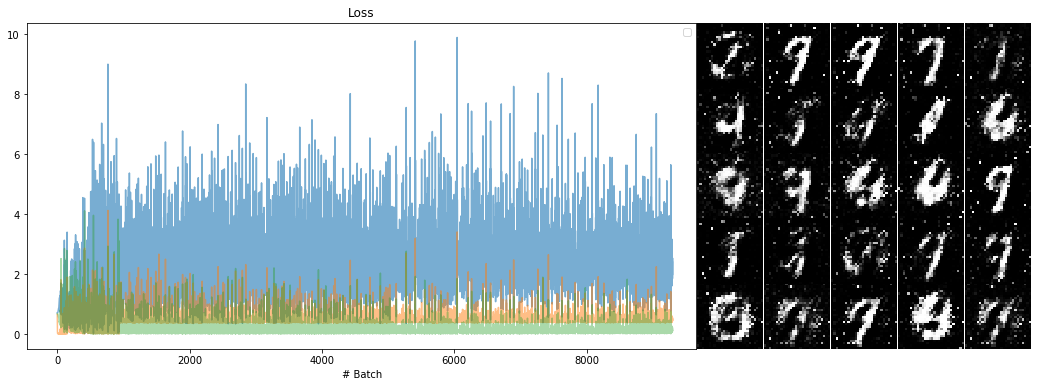

In [458]:
gan = GAN_MNIST()
gan.train()

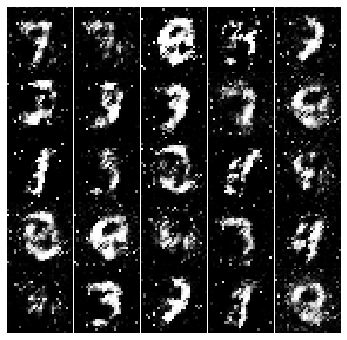

In [459]:
gan.generate_images(plot=True);